# Hedge fund transparency: quantifying valuation bias for illiquid assets

    [1] Weinstein, E. & Abdulali, A," Towards Hedge Fund Transparency: 
    Quantifying Valuation Bias for Illiquid Assets", Risk, Spring 2002
    
### Abstract
Risk measures, such as the Sharpe ratio, used by investment professionals are only as good as the accuracy of the asset price data used to derive them. Nowhere is this issue more relevant than for hedge funds, which often invest in less liquid assets such as convertible bonds. Here, Eric Weinstein and Adil Abdulali devise a ‘phantom price’ framework for illiquid assets and show how to generalise the Sharpe ratio to incorporate liquidity risk

In [2]:
# Useful system libraries
import os
import warnings

# Useful data libraries
import numpy as np
import pandas as pd

# Useful viz libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

# Useful time libraries
from datetime import datetime, timedelta
import pytz

# Preferred notebook settings
%matplotlib inline
# mpl.style.use('ggplot')
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 20)
warnings.filterwarnings('ignore')

## Definitions

### English Terms
* __"Translucent" Assets__ - include mortgage-backed securities, high-yield bonds, certain convertible bonds and others. Assets traded so privately or with such infrequency that transaction prices are not readily available for pricing.

Let $v_t$ be the vector of indicative prices in period $t$ and assume that the representative investor has Von-Neumann-Morgenstern risk preferences given by the sub-utility function $u$ in period $t$. If given $v$ the representative investor believes that $B_{v_t}$ is the probability distribution generating the sample, the result will be a set of time-dependent phantom prices:

$$\mathbb{P}(\mathit{v_t})=\mathit{u_t}^{-1}\int_{\mathbb{R}_+}\mathit{u_t}(\mathit{x})\mathit{\beta_{\mathit{v_t}}(\mathit{x})}dx$$

### Mathematical Terms
* $\mathit{m}$ : number of broker-dealer valuations we call _indicative prices_. What people think the price might be.
* $\mathit{v_t}\in \mathbb{R}_{+}^{m}$ : a vector of _indicative prices_ that must be positive and real. We represent market beliefs as a probability distribution constructed from indicative prices.
* $\Psi_{[\alpha,\lambda]}^{\Gamma}(x)=\frac{\lambda^{-\alpha}\exp^{-\frac{x}{\lambda}}x^{\alpha-1}}{\Gamma[\alpha]}$ : Gamma distribution representing investor beliefs. This is the distribution we assume create the sample vector of price quotes we store in our pandas dataframe. It does not associate positive probabilities with negative price quotes like a normal distribution would.
* $\mathit{u_\alpha}(x)=\begin{cases} \frac{x^{1-\alpha}}{1-\alpha} & \alpha\neq 1 \\ \ln[x] & \alpha=1 \end{cases}$ : Is the risk preference modeling function. Deciding the representative price involves the risk tolerance of the person ascribing a value to the asset. Higher values are associated with *increasing* risk aversion.

In [3]:
import scipy.special as sps

# For each security in our portfolio, there is a collection of m broker-dealers 
# who are willing and able in every period t to give indicative prices
m = 5

sample_v_t = np.array([59.0, 60.2, 65.5, 68.0, 70.0])

# Sample mean
def mu(v_t):
    return np.mean(v_t)

# Sample variance
def sigma2(v_t):
    return np.var(v_t)

# Risk Preferences
def u_t(alpha, x):
    if alpha == 1:
        return np.log(x)
    else:
        return (x**(alpha-1))/(1-alpha)
    
# 
def phantom_price(alpha, v_t):
    mean = np.mean(v_t)
    var = np.var(v_t)
    return (var/mean)*((sps.gamma((mean**2)-((alpha-1)*(var**2))))/(sps.gamma((mean**2)/(var**2))))**(1.0/(1-alpha))

In [4]:
phantom_price(1.5, sample_v_t)

0.0

## Interesting problem I did not forsee, numbers are not within computer memory range

    Time to investigate Symbolic Computation! (Also called "Computer Algebra Systems")

### This is an extraneous cell for visualizing gamma distribution

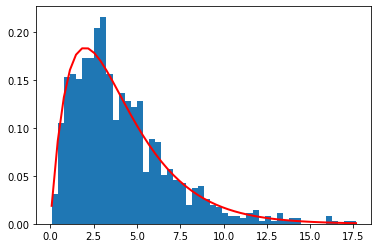

In [5]:
import matplotlib.pyplot as plt

shape, scale = 2., 2.  # mean=4, std=2*sqrt(2)
s = np.random.gamma(shape, scale, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /
                      (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')
# plt.show()

### Time series for broker-dealer quotes on an MBS Derivative

<img src=img/illiquid_asset_pricing_data.png style='width:400px;height:400px'/>

We define the time series data found in Figure 1 on the first page as a Pandas DataFrame.

In [6]:
FNR_99_15_SB = pd.DataFrame(np.array([[79.0,81.9,82.0,83.7,84.0],
                                      [78.0,79.0,81.9,82.0,83.7],
                                      [59.0,60.2,65.5,68.0,70.0],
                                      [70.0,72.0,74.0,77.0,79.0],
                                      [64.0,65.0,68.0,69.0,74.0],
                                      [66.0,69.0,71.0,75.0,76.0],
                                      [80.0,86.0,87.9,87.9,91.3],
                                      [92.6,93.5,96.4,100.5,100.5]]),
                            columns=['Quote 1','Quote 2','Quote 3','Quote 4','Quote 5'],
                            index=['Jun 99','Sep 99','Dec 99','Mar 00','Jun 00', 'Sep 00', 'Dec 00', 'Mar 01'])
FNR_99_15_SB

,Quote 1,Quote 2,Quote 3,Quote 4,Quote 5
Jun 99,79.0,81.9,82.0,83.7,84.0
Sep 99,78.0,79.0,81.9,82.0,83.7
Dec 99,59.0,60.2,65.5,68.0,70.0
Mar 00,70.0,72.0,74.0,77.0,79.0
Jun 00,64.0,65.0,68.0,69.0,74.0
Sep 00,66.0,69.0,71.0,75.0,76.0
Dec 00,80.0,86.0,87.9,87.9,91.3
Mar 01,92.6,93.5,96.4,100.5,100.5


Each row is a vector $\mathit{v_t}$ at time $t$ where $\mathit{v_t}\in\mathbb{R}_{+}^{5}$

In [7]:
from sympy import (
    init_printing,
    symbols,
    Piecewise,
    Rational,
    ln,
    gamma,
    euler,
    factorial,
    Sum
)
init_printing()

Define a __shape parameter__ $\mathbf{\alpha}$ and a __scale parameter__ $\mathbf{\lambda}$

In [8]:
x = symbols('x')
a = symbols('a')
alpha = symbols('alpha')
Lambda = symbols('\lambda')
mu = symbols('mu_t', real=True)
sigma2 = symbols('\sigma_t^2', positive=True)
x, a, alpha, Lambda, mu, sigma2

___
### Define Case 1 where $a\neq0$

Since I'm new to SymPy, we're going to define this in parts then bring it all together.

First up is the normalization factor out front

In [9]:
(sigma2/mu)

Now the numerator of the fraction raised to $\frac{1}{1-a}$

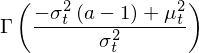

In [10]:
gamma((mu**2-((a-1)*sigma2))/sigma2)

Now the denominator

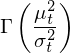

In [11]:
gamma(mu**2/sigma2)

And finally bring it all together

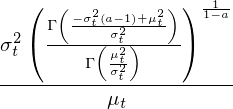

In [12]:
phantom_price_1=(sigma2/mu)*(gamma((mu**2-((a-1)*sigma2))/sigma2)/ \
                             gamma(mu**2/sigma2))**(1/(1-a))
phantom_price_1

Now we solve by subbing in some numbers for the variables

In [13]:
phantom_price_1.subs(mu, FNR_99_15_SB.loc['Jun 99'].mean()) \
               .subs(sigma2, FNR_99_15_SB.loc['Jun 99'].var()) \
               .subs(a, 100)

In [14]:
FNR_99_15_SB.loc['Jun 99'].mean()

#### We can check correct implementation with $a=0$ as this should just give us back the straight arithmetic mean

In [15]:
Eq(phantom_price_1.subs(mu, FNR_99_15_SB.loc['Jun 99'].mean()) \
                .subs(sigma2, FNR_99_15_SB.loc['Jun 99'].var()) \
                .subs(a, 0),
FNR_99_15_SB.loc['Jun 99'].mean())

#### Woohoo!

But this is the only the first case, there's a discontinuity at $a=1$ so we will define the second case below

___
### Define Case 2 where $a=1$

__First Term__

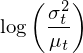

In [16]:
ln(sigma2/mu)

__Second Term Numerator__

In [26]:
gamma(alpha).diff()#.subs(alpha, (mu**2/sigma2).subs(mu, FNR_99_15_SB.loc['Jun 99'].mean()) \
                   #                           .subs(sigma2, FNR_99_15_SB.loc['Jun 99'].var()))

This function does not give us the desired answer when evaluated. Unsure w.r.t. which variable I should be taking the derivative.
* just had a thought maybe you take the derivative w.r.t. $\alpha$ but it's simply calculated as the variable substitution $\alpha=\frac{\mu_t^2}{\sigma_t^2}$
  * ^ cell above is this attempt with no success, I might need to go over my own head to someone in the math department.
  * below is my attempt at numerical estimation, though it hasn't panned out as I haven't figured out how to make the lazy constant and sum compatible operations - currently throws an error is mpmath is imported.

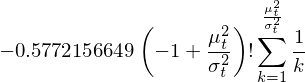

In [18]:
# factorial()
m = mu**2/sigma2
k = symbols('k', real=True)
# factorial(m-1)*(-euler*
# Sum(1/k, (k, 1, m))
# from mpmath import *
# mp.dps = 50; mp.pretty = True
gamm_deriv_estimate = factorial(m-1)*(-0.5772156649)*Sum(1/k, (k, 1, m))
gamm_deriv_estimate

Second Term Denominator

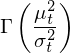

In [19]:
gamma(mu**2/sigma2)

Bringing it all together

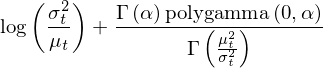

In [20]:
phantom_price_2 = ln(sigma2/mu) + gamma(alpha).diff()/gamma(mu**2/sigma2)
phantom_price_2

In [21]:
phantom_price_2.subs(alpha, (mu**2/sigma2)) \
               .subs(mu, FNR_99_15_SB.loc['Jun 99'].mean()) \
               .subs(sigma2, FNR_99_15_SB.loc['Jun 99'].var()) \
               .subs(a, 1) \
               .evalf()

___
### Okay so my divide by zero case hasn't worked out quite like I wanted
* Going to continue on to graph generation anyway until I figure out how to work with the gamma derivative or estimating with the euler constant

#### My goal is to reproduce the following graph

<img src=img/3d-price-graph.png style='width:500px;height:350px'/>

#### Define the phantom pricing function with three variable
* price_quotes is our pricing distribution
    - Wow I just realized this is basically advanced label aggregation
* risk_pref is our `a` parameter 
    - specifies risk aversion; higher vals are more risk averse

In [22]:
def calculate_price(mean, var, risk_pref):
    if risk_pref == 1:
        pass # this will become phantom_price_2 equation
    else:
        return phantom_price_1.subs(mu, mean) \
                              .subs(sigma2, var) \
                              .subs(a, risk_pref)

Now plot the 3D graph

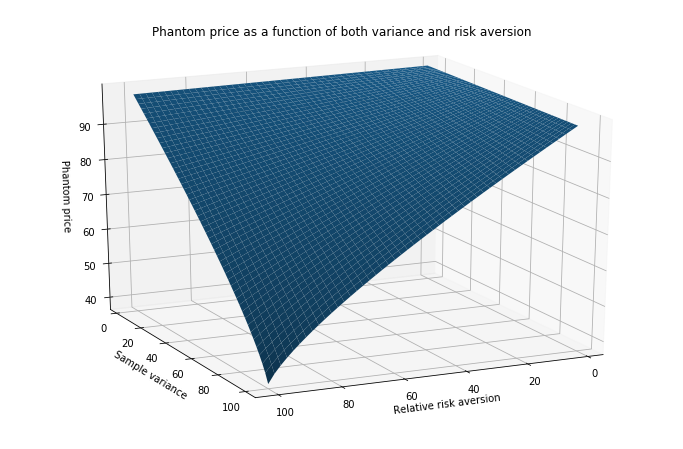

In [23]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

relative_risk_aversion = np.linspace(2,100) # both start from 2
sample_variance = np.linspace(2,100)        # not full implementation yet
X, Y = np.meshgrid(relative_risk_aversion, sample_variance)
price = np.array([[calculate_price(100, X[idx,inner_idx], Y[idx,inner_idx]) \
                   for inner_idx in range(X[idx].shape[0])] \
                  for idx in range(X.shape[0])], dtype=float)

ax.plot_surface(X, Y, price);
ax.set_xlabel('Relative risk aversion')
ax.set_ylabel('Sample variance')
ax.set_zlabel('Phantom price')
ax.set_title('Phantom price as a function of both variance and risk aversion')
ax.view_init(20, 65);

# We did it!

Graph is from another angle and still doesn't calculate for risk preference $a=1$ edge case, but other than that its identical!

___
\*Cue Billy Mayes Voice\* 
# But wait, there's more!